In [1]:
from SocialNetwork.social_network_environment import *
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
#from SocialNetwork.cascade import *
from Advertising.learners.Greedy_algorithm import *
from Advertising.learners.UCB_no_anything import *
from Advertising.learners.UCB_no_qualities import *
arms = arms_creation(seed = 30291, number_of_arms= 20)
seed = 6789 
random.seed(seed)

exploration=4.2

deltas=[0.5,0.42,0.38,0.30,0.2,0.05]

social_network = social_network_environment()
social_network.init_from_json(json_path_network='Config/network.json', json_path_features='Config/features.json')



n_rounds=10000
estimation_rounds=2000
vcg=VCG()
nodes_estimation=[]
with open('Config/estimated_influence.json', 'r') as file:
    data = json.load(file)
    nodes_estimation = data.get('estimated_influence')

In [2]:
from tqdm.notebook import tqdm_notebook

def create_adv_bids():
    
    adversary_bids = []
    for _ in range(0, 10): 
        adversary_i_bids = []
        for _ in range(0, 5):
            adversary_i_bids.append(random.randint(0, 4))
        adversary_bids.append(adversary_i_bids)
    return adversary_bids

def experiment(rounds, learner, all_bids, first = False, qualities = False):
    
    vcg = VCG()

    for t in tqdm_notebook(range(0, rounds)):

        index=learner.pull_arm()
        best_arm = arms[index]


        all_bids.insert(0, best_arm)
        ad_allocation_list = setup(bids=all_bids, n_bids=5)
        best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)

        if first:
            for j in range(0, len(best_allocation)):
                temp_allocation = []
                temp_allocation = best_allocation[j]
                for k in range(0, len(best_allocation[j])):
                    if temp_allocation[k].ad_id == 1 and k != 0:
                        temp_allocation[k].ad_id = None
                        best_allocation[j] = temp_allocation

        # Computing payments
        payments = vcg.payments(ad_allocation_list, best_allocation, social_network)

        if qualities:
            active_nodes, total_reward = active_nodes_click(social_network, best_allocation, deltas, learner_id=1)
        else:     
            active_nodes, total_reward = activate_cascade(social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas,learner_id=1)

        payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)


        reward = (total_reward-payments_tot)

        if qualities:
            learner.update(index, reward, np.where(active_nodes==1)[0])
        else:
            learner.update(index, reward)

        all_bids.pop(0)
        reset_nodes(social_network)

# Function for computing the rolling mean (i.e. moving average)
def compute_ma(collected_rewards):
    ma = []
    ma.append(0)

    for t in range(1,len(collected_rewards)):
        ma.append((ma[-1] * (t-1) +collected_rewards[t]) / t)
    
    return ma

def plot_clairvoyant(learner, clairvoyant):
    collected_rewards = learner.collected_rewards
    rolling_mean = compute_ma(collected_rewards)
    clairvoyant = clairvoyant

    plt.figure()
    plt.axhline(y = clairvoyant, color = 'r', linestyle = '-')
    plt.plot(rolling_mean, color = 'b')
    plt.show()

all_bids = create_adv_bids()

In [3]:
with open('Config/clairvoyants.json', 'r') as clair_file:
    data = json.load(clair_file)
    clairvoyant_q_f = data.get('clairvoyant_q_f')
    clairvoyant_q_a = data.get('clairvoyant_q_a')
    clairvoyant_nq_f = data.get('clairvoyant_nq_f')
    clairvoyant_nq_a = data.get('clairvoyant_nq_a')

print(clairvoyant_q_f)
print(clairvoyant_q_a)
print(clairvoyant_nq_f)
print(clairvoyant_nq_a)

0.24936147844443757
0.48842019490079885
1.7742390000000792
2.1363950000000385


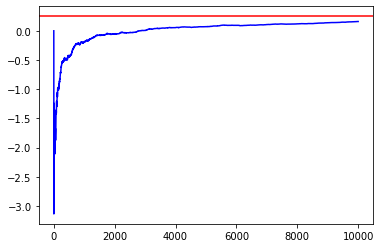

[-3.50099015  0.19611019 -4.56468677 -1.59067893  0.32103952 -2.26269034
 -2.7915299  -1.26322875 -2.57175942 -3.29694255 -1.89632895 -1.21944777
 -2.65871083 -8.53126005  0.         -3.59628611 -4.436313   -1.4665174
  0.         -2.47935968]
[1, 1, 2, 0, 4]


In [4]:
from Advertising.learners.UCB_Learner_qualities import*
learner = UCB_Learner_qualities(arms = arms, hyperpar = exploration, nodes_estimation = nodes_estimation)

experiment(rounds = n_rounds, learner = learner, all_bids = all_bids, first = True, qualities = True)

# Plotting
plot_clairvoyant(learner = learner, clairvoyant=clairvoyant_q_f)
print(learner.exp_values)
print(arms[learner.return_best_arm()])


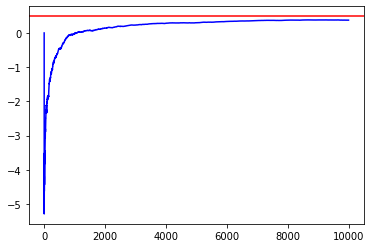

[-3.69687701 -4.74803229 -3.52980056 -2.40743965 -0.4781111  -3.67332977
 -2.20943148 -0.99312508 -6.48385389 -5.04857657 -3.42380137 -2.80836944
 -2.76190238 -9.62106759  0.4718384  -5.60483341 -6.55216632 -1.68123229
 -2.52598211 -4.80115614]
[2, 3, 2, 1, 1]


In [5]:
learner = UCB_Learner_qualities(arms = arms, hyperpar = exploration, nodes_estimation = nodes_estimation)

experiment(rounds = n_rounds, learner = learner, all_bids = all_bids, first = False, qualities = True)

# Plotting
plot_clairvoyant(learner = learner, clairvoyant=clairvoyant_q_a)
print(learner.exp_values)
print(arms[learner.return_best_arm()])

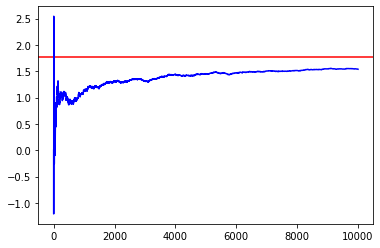

[-0.0797619   1.74386217  0.09844828  1.3747411   0.66630631  0.39173333
 -2.339       1.2574321  -0.61307692 -1.57714286  1.0132093   1.28644144
  0.49174419 -5.784       0.          0.828      -0.05977273 -0.27916667
  0.          0.74224   ]
[3, 3, 4, 2, 3]


In [6]:
from Advertising.learners.UCB_Learner import *
learner = UCB_Learner(arms = arms, hyperpar = exploration)

experiment(rounds = n_rounds, learner = learner, all_bids = all_bids, first = True, qualities = False)

# Plotting
plot_clairvoyant(learner = learner, clairvoyant=clairvoyant_nq_f)
print(learner.exp_values)
print(arms[learner.return_best_arm()])

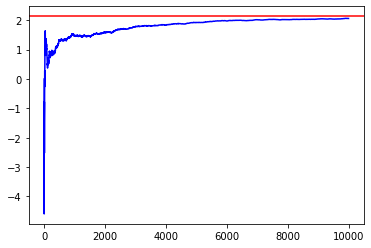

[ -1.40105263  -3.97188388   0.07416667   0.68661202   1.7648785
  -0.06509868  -4.065        0.7228125  -10.78714286  -7.60868421
   0.83792208   0.21227596   1.15142857  -3.41166667   2.19567636
  -3.33798246  -0.19692308   0.7196875    0.67149527  -4.33356516]
[2, 3, 2, 1, 1]


In [7]:
learner = UCB_Learner(arms = arms, hyperpar = exploration)

experiment(rounds = n_rounds, learner = learner, all_bids = all_bids, first = False, qualities = False)

# Plotting
plot_clairvoyant(learner = learner, clairvoyant=clairvoyant_nq_a)
print(learner.exp_values)
print(arms[learner.return_best_arm()])


In [2]:
#Clairvoyant for point 4, only first position
all_exp_rewards=[]
for arm in arms:
    print("Doing arm "+ str(arm))
    exp_reward=0
    all_bids.insert(0, arm)
    ad_allocation_list = setup(bids=all_bids, n_bids=5)
    best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)
    for j in range(0, len(best_allocation)):
            temp_allocation = []
            temp_allocation = best_allocation[j]
            for k in range(0, len(best_allocation[j])):
                if temp_allocation[k].ad_id == 1 and k != 0:
                    temp_allocation[k].ad_id = None
                    best_allocation[j] = temp_allocation
    for i in range(1, n_rounds+1):  
        payments = vcg.payments(ad_allocation_list, best_allocation, social_network)
        active_nodes, reward_click = active_nodes_click(social_network, best_allocation, deltas, learner_id=1)
        reward_influence = 0
        seeds=np.where(active_nodes==1)[0]
        if len(seeds) != 0:
            for k in range(0, len(seeds)):
                reward_influence += nodes_estimation[seeds[k]]
            reward_influence = reward_influence/len(seeds)# + reward_influence)/2
        payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)
        reward = (reward_click+reward_influence-payments_tot) 
        reset_nodes(social_network)
    
        exp_reward = (exp_reward*(i-1) + reward)/i
    all_bids.pop(0)
    all_exp_rewards.append(exp_reward)

clairvoyant_q_f=max(all_exp_rewards)
index_q_f=np.argmax(all_exp_rewards)

Doing arm [4, 1, 1, 3, 0]
Doing arm [3, 3, 4, 2, 3]
Doing arm [1, 4, 3, 2, 0]
Doing arm [1, 3, 3, 1, 4]
Doing arm [1, 1, 2, 0, 4]
Doing arm [2, 4, 4, 3, 0]
Doing arm [4, 0, 0, 0, 1]
Doing arm [2, 1, 3, 0, 4]
Doing arm [4, 2, 2, 2, 4]
Doing arm [0, 4, 3, 3, 1]
Doing arm [2, 3, 4, 2, 4]
Doing arm [2, 2, 3, 3, 4]
Doing arm [0, 4, 4, 2, 1]
Doing arm [4, 2, 3, 4, 0]
Doing arm [2, 3, 2, 1, 1]
Doing arm [1, 4, 4, 2, 3]
Doing arm [0, 0, 4, 4, 4]
Doing arm [0, 0, 1, 4, 0]
Doing arm [3, 1, 2, 2, 3]
Doing arm [3, 4, 3, 3, 0]


In [3]:
#Clairvoyant for point 4, with all positions
all_exp_rewards=[]
for arm in arms:
    print("Doing arm "+ str(arm))
    exp_reward=0
    all_bids.insert(0, arm)
    ad_allocation_list = setup(bids=all_bids, n_bids=5)
    best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)
    for i in range(1, n_rounds+1):  
        payments = vcg.payments(ad_allocation_list, best_allocation, social_network)
        active_nodes, reward_click = active_nodes_click(social_network, best_allocation, deltas, learner_id=1)
        reward_influence = 0
        seeds=np.where(active_nodes==1)[0]
        if len(seeds) != 0:
            for k in range(0, len(seeds)):
                reward_influence += nodes_estimation[seeds[k]]
            reward_influence = reward_influence/len(seeds)# + reward_influence)/2
        payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)
        reward = (reward_click+reward_influence-payments_tot) 
        reset_nodes(social_network)
    
        exp_reward = (exp_reward*(i-1) + reward)/i
    all_bids.pop(0)
    all_exp_rewards.append(exp_reward)

clairvoyant_q_a=max(all_exp_rewards)
index_q_a=np.argmax(all_exp_rewards)

Doing arm [4, 1, 1, 3, 0]
Doing arm [3, 3, 4, 2, 3]
Doing arm [1, 4, 3, 2, 0]
Doing arm [1, 3, 3, 1, 4]
Doing arm [1, 1, 2, 0, 4]
Doing arm [2, 4, 4, 3, 0]
Doing arm [4, 0, 0, 0, 1]
Doing arm [2, 1, 3, 0, 4]
Doing arm [4, 2, 2, 2, 4]
Doing arm [0, 4, 3, 3, 1]
Doing arm [2, 3, 4, 2, 4]
Doing arm [2, 2, 3, 3, 4]
Doing arm [0, 4, 4, 2, 1]
Doing arm [4, 2, 3, 4, 0]
Doing arm [2, 3, 2, 1, 1]
Doing arm [1, 4, 4, 2, 3]
Doing arm [0, 0, 4, 4, 4]
Doing arm [0, 0, 1, 4, 0]
Doing arm [3, 1, 2, 2, 3]
Doing arm [3, 4, 3, 3, 0]


In [4]:
#Clairvoyant for point 5, only first position
all_exp_rewards=[]
for arm in arms:
    print("Doing arm "+ str(arm))
    exp_reward=0
    all_bids.insert(0, arm)
    ad_allocation_list = setup(bids=all_bids, n_bids=5)
    best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)
    for j in range(0, len(best_allocation)):
            temp_allocation = []
            temp_allocation = best_allocation[j]
            for k in range(0, len(best_allocation[j])):
                if temp_allocation[k].ad_id == 1 and k != 0:
                    temp_allocation[k].ad_id = None
                    best_allocation[j] = temp_allocation
    for i in range(1, n_rounds+1):  
        payments = vcg.payments(ad_allocation_list, best_allocation, social_network)
        active_nodes, total_reward = activate_cascade(social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas,learner_id=1)
        payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)
        reward = (total_reward-payments_tot) 
        reset_nodes(social_network)
        exp_reward = (exp_reward*(i-1) + reward)/i
    all_bids.pop(0)
    all_exp_rewards.append(exp_reward)

clairvoyant_nq_f=max(all_exp_rewards)
index_nq_f=np.argmax(all_exp_rewards)

Doing arm [4, 1, 1, 3, 0]
Doing arm [3, 3, 4, 2, 3]
Doing arm [1, 4, 3, 2, 0]
Doing arm [1, 3, 3, 1, 4]
Doing arm [1, 1, 2, 0, 4]
Doing arm [2, 4, 4, 3, 0]
Doing arm [4, 0, 0, 0, 1]
Doing arm [2, 1, 3, 0, 4]
Doing arm [4, 2, 2, 2, 4]
Doing arm [0, 4, 3, 3, 1]
Doing arm [2, 3, 4, 2, 4]
Doing arm [2, 2, 3, 3, 4]
Doing arm [0, 4, 4, 2, 1]
Doing arm [4, 2, 3, 4, 0]
Doing arm [2, 3, 2, 1, 1]
Doing arm [1, 4, 4, 2, 3]
Doing arm [0, 0, 4, 4, 4]
Doing arm [0, 0, 1, 4, 0]
Doing arm [3, 1, 2, 2, 3]
Doing arm [3, 4, 3, 3, 0]


In [5]:
#Clairvoyant for point 5, with all positions
all_exp_rewards=[]
for arm in arms:
    print("Doing arm "+ str(arm))
    exp_reward=0
    all_bids.insert(0, arm)
    ad_allocation_list = setup(bids=all_bids, n_bids=5)
    best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)
    for i in range(1, n_rounds+1):  
        payments = vcg.payments(ad_allocation_list, best_allocation, social_network)
        active_nodes, total_reward = activate_cascade(social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas,learner_id=1)
        payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)
        reward = (total_reward-payments_tot) 
        reset_nodes(social_network)
        exp_reward = (exp_reward*(i-1) + reward)/i
    all_bids.pop(0)
    all_exp_rewards.append(exp_reward)

clairvoyant_nq_a=max(all_exp_rewards)
index_nq_a=np.argmax(all_exp_rewards)
        

Doing arm [4, 1, 1, 3, 0]
Doing arm [3, 3, 4, 2, 3]
Doing arm [1, 4, 3, 2, 0]
Doing arm [1, 3, 3, 1, 4]
Doing arm [1, 1, 2, 0, 4]
Doing arm [2, 4, 4, 3, 0]
Doing arm [4, 0, 0, 0, 1]
Doing arm [2, 1, 3, 0, 4]
Doing arm [4, 2, 2, 2, 4]
Doing arm [0, 4, 3, 3, 1]
Doing arm [2, 3, 4, 2, 4]
Doing arm [2, 2, 3, 3, 4]
Doing arm [0, 4, 4, 2, 1]
Doing arm [4, 2, 3, 4, 0]
Doing arm [2, 3, 2, 1, 1]
Doing arm [1, 4, 4, 2, 3]
Doing arm [0, 0, 4, 4, 4]
Doing arm [0, 0, 1, 4, 0]
Doing arm [3, 1, 2, 2, 3]
Doing arm [3, 4, 3, 3, 0]


In [6]:
all_clairvoyants = []
all_clairvoyants.append(clairvoyant_q_f)
all_clairvoyants.append(clairvoyant_q_a)
all_clairvoyants.append(clairvoyant_nq_f)
all_clairvoyants.append(clairvoyant_nq_a)
all_indexes = []
all_indexes.append(index_q_f)
all_indexes.append(index_q_a)
all_indexes.append(index_nq_f)
all_indexes.append(index_nq_a)

In [10]:
print(all_exp_rewards)

[-0.35328010526315773, 0.00011997493734329829, 0.6465869999999866, 1.2689900000000092, 1.8127010000000245, -0.3900337894736869, -0.09246100000000279, 1.4587190000000214, -1.0319124285714323, -0.32833947368421224, 1.2106723333333371, 0.5977858421052612, 0.5207969999999917, -2.886649999999981, 2.1363950000000385, 0.1837472631578926, -0.6554040000000033, 0.941994000000002, 0.9879567794486238, -2.6038772305764595]


In [7]:
print(all_clairvoyants)
print(all_indexes)

[0.24936147844443757, 0.48842019490079885, 1.7742390000000792, 2.1363950000000385]
[4, 14, 1, 14]


In [9]:
import json
with open('Config/clairvoyants.json', 'w') as file:
    to_write = {'clairvoyant_q_f': clairvoyant_q_f, 'clairvoyant_q_a': clairvoyant_q_a, 'clairvoyant_nq_f': clairvoyant_nq_f, 'clairvoyant_nq_a': clairvoyant_nq_a}
    json.dump(to_write, file)
    
